In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../data/raw/data.csv')

/tmp/ipykernel_25735/1673262403.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='viridis')
/tmp/ipykernel_25735/1673262403.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Verdadero (0)', 'Falso (1)'])


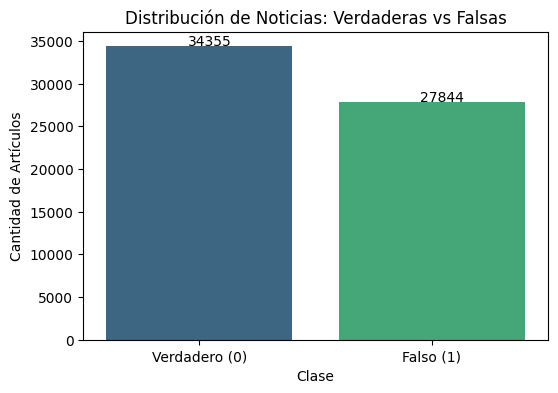

In [4]:
plt.figure(figsize=(6, 4))

# Creamos el gráfico de barras
ax = sns.countplot(x='label', data=df, palette='viridis')

# Ponemos etiquetas más claras en el eje X
ax.set_xticklabels(['Verdadero (0)', 'Falso (1)'])
plt.title('Distribución de Noticias: Verdaderas vs Falsas')
plt.ylabel('Cantidad de Artículos')
plt.xlabel('Clase')

# (Opcional) Agregar el número exacto encima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 100))

plt.show()

count    62199.000000
mean       544.797039
std        610.001573
min          0.000000
25%        241.000000
50%        404.000000
75%        673.000000
max      24234.000000
Name: word_count, dtype: float64


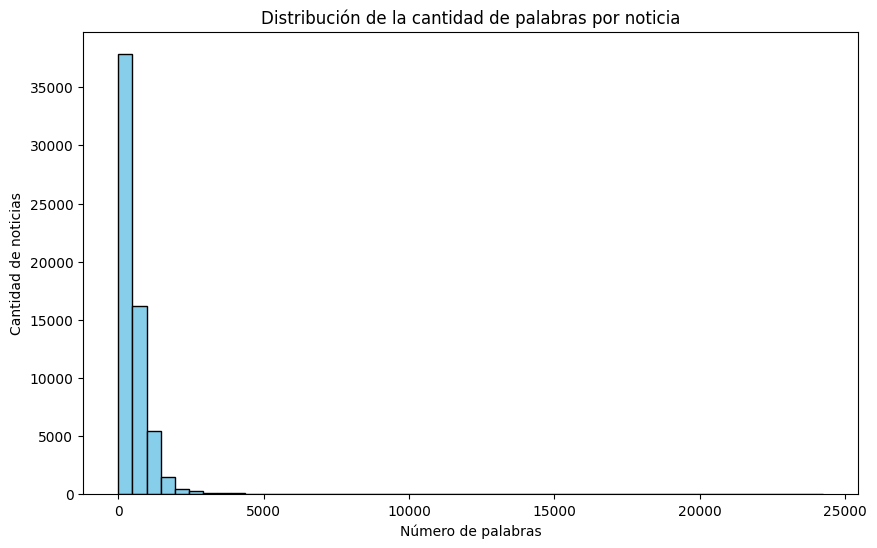

In [31]:
# Crear una columna temporal con el conteo de palabras
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Ver estadísticas básicas
print(df['word_count'].describe())

# Graficar la distribución
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de la cantidad de palabras por noticia')
plt.xlabel('Número de palabras')
plt.ylabel('Cantidad de noticias')
plt.show()

In [32]:
# Filtramos donde word_count es 0
registros_cero = df[df['word_count'] == 0]

print(f"Cantidad de registros con 0 palabras: {len(registros_cero)}")

registros_cero.head()

Cantidad de registros con 0 palabras: 529


,title,text,label,word_count
17,WATCH HUGE CROWD CHEER When Asked If Trump Should “Win For America” [Video],,1,0
424,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER FOR “ROLLING RELEASE” OF CLINTON E-MAILS,,1,0
449,NYT: Whites Must Know Their Place,,1,0
512,BILL O’REILLY Destroys Liberal Pundit On Trump Coverage [Video],,1,0
563,"FUNNIEST INAUGURATION MOMENT: WATCHING Reaction Of Dick Cheney, As George W. Bush Tries To Put On A Rain Poncho…PRICELESS! [VIDEO]",,1,0


In [33]:
# Filtramos donde word_count es menor a 20 (por ejemplo)
registros_cortos = df[df['word_count'] < 20].sort_values(by='word_count')

print(f"\nCantidad de registros con menos de 20 palabras: {len(registros_cortos)}")


Cantidad de registros con menos de 20 palabras: 1204


In [34]:
# Definimos el umbral
MIN_PALABRAS = 20

# Filtramos
print(f"Filas antes de borrar cortas: {len(df)}")
df_final = df[df['word_count'] >= MIN_PALABRAS].copy()
print(f"Filas después de borrar cortas: {len(df_final)}")

# Reseteamos el índice para que quede ordenado 0, 1, 2...
df_final.reset_index(drop=True, inplace=True)

Filas antes de borrar cortas: 62199
Filas después de borrar cortas: 60995


In [35]:
import re
import string
import nltk
from nltk.corpus import stopwords

In [36]:
# Descargar el paquete de stopwords (solo necesitas ejecutarlo una vez)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def limpiar_texto(text):
    # 1. Convertir a minúsculas
    text = str(text).lower()
    
    # 2. Eliminar URLs (http, https, www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)
    
    # 4. Eliminar lo que está entre corchetes (ej: [VIDEO])
    text = re.sub(r'\[.*?\]', '', text)
    
    # 5. Eliminar signos de puntuación
    # string.punctuation incluye: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    # 6. Eliminar saltos de línea
    text = re.sub(r'\n', ' ', text)
    
    # 7. Eliminar palabras que contengan números (opcional, ej: w3c, covid19 -> covid)
    text = re.sub(r'\w*\d\w*', '', text)
    
    # 8. Eliminar Stopwords (Palabras vacías)
    # Separamos en palabras, filtramos y volvemos a unir
    words = text.split()
    words = [w for w in words if w not in stop_words]
    text = ' '.join(words)
    
    return text

# --- APLICAR LA LIMPIEZA ---
print("Iniciando limpieza de texto... esto puede tardar un poco dependiendo de tu RAM.")

# Creamos una columna nueva para comparar (o puedes sobrescribir 'text')
df_final['text_clean'] = df_final['text'].apply(limpiar_texto)

print("¡Limpieza terminada!")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Iniciando limpieza de texto... esto puede tardar un poco dependiendo de tu RAM.
¡Limpieza terminada!


In [37]:
pd.set_option('display.max_colwidth', 150) # Ampliar ancho para leer mejor

print(df_final[['text', 'text_clean']].head(5))

# Verificamos si quedaron filas vacías DESPUÉS de limpiar
# (Ej: una noticia que solo tenía stopwords como "The is of a")
vacios_post_limpieza = df_final[df_final['text_clean'] == ''].shape[0]
print(f"\nFilas que quedaron vacías después de limpiar: {vacios_post_limpieza}")

                                                                                                                                                    text  \
0  Taking Social Security benefits early comes with a price, yet more than 4 in 10 Americans who are 50 and over say they'll dip into the program bef...   
1  Trending Articles: Trending Articles: ‘Chairman Cash’ – John Podesta is Paid $7,000 a Month by Foundation Run by Banker With Ties to Financial Cri...   
2  DES MOINES, Iowa (Reuters) - In 2015, it wasn’t the new breed of political groups that can raise as much as billionaires will give them that spent...   
3  Indiana Governor Mike Pence is at the center of a political and human rights predicament of his own making.It all relates to what he said   or wha...   
4  There has always been an odd tenor to discussions among climate scientists, policy wonks, and politicians, a passive-aggressive quality, and I thi...   

                                                               

In [39]:
#elimnar filas con 'text_clean' vacío
df_final = df_final[df_final['text_clean'] != ''].copy()
print(f"Filas antes de borrar cortas: {len(df_final)}")
print(f"Filas después de borrar cortas: {len(df_final)}")

Filas antes de borrar cortas: 60994
Filas después de borrar cortas: 60994


count    60994.000000
mean        12.005164
std          3.805886
min          1.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         58.000000
Name: word_count_title, dtype: float64


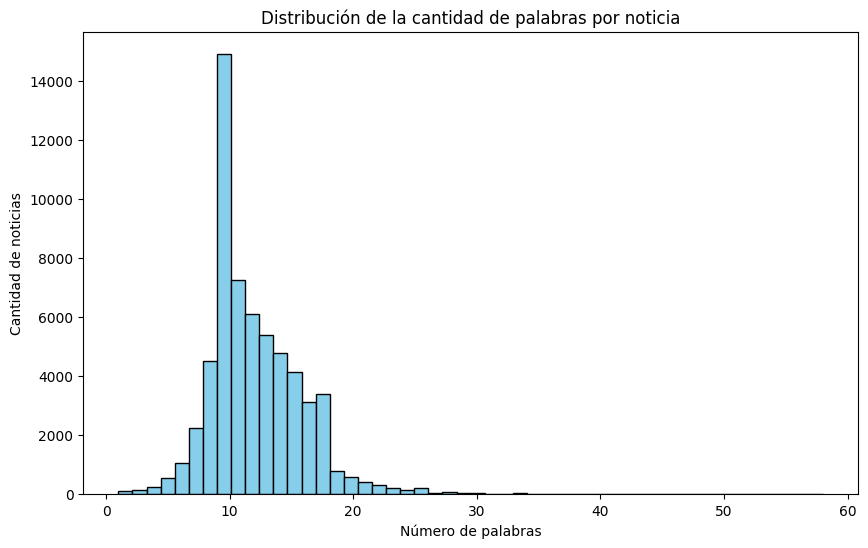

In [41]:
# Crear una columna temporal con el conteo de palabras
df_final['word_count_title'] = df_final['title'].apply(lambda x: len(str(x).split()))

# Ver estadísticas básicas
print(df_final['word_count_title'].describe())

# Graficar la distribución
plt.figure(figsize=(10, 6))
plt.hist(df_final['word_count_title'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de la cantidad de palabras por noticia')
plt.xlabel('Número de palabras')
plt.ylabel('Cantidad de noticias')
plt.show()

In [42]:
# Aplicamos la limpieza a la columna 'title'
print("Limpiando títulos...")
df_final['title_clean'] = df_final['title'].apply(limpiar_texto)

# Verificamos cómo quedó
print(df_final[['title', 'title_clean']].head())

Limpiando títulos...
                                                                                                             title  \
0                                                      Many Opt to Take Social Security Before Full Retirement Age   
1  ‘Chairman Cash’ – John Podesta is Paid $7,000 a Month by Foundation Run by Banker With Ties to Financial Crisis   
2                                             Outside campaign groups lag U.S. presidential candidates in spending   
3                 Conservative Indiana Governor’s Stupid Response To LGBT Question Gets Him In Big Trouble (VIDEO)   
4                                                       The awful truth about climate change no one wants to admit   

                                                                             title_clean  
0                                      many opt take social security full retirement age  
1  ‘chairman cash’ – john podesta paid month foundation run banker ties financial crisis

In [43]:
# Concatenamos con un espacio en el medio para que no se peguen las palabras
# Ejemplo: "titulo final" + " " + "inicio del texto"
df_final['combined_text'] = df_final['title_clean'] + " " + df_final['text_clean']

# Verificar si alguna combinación quedó vacía (raro, pero posible)
df_final = df_final[df_final['combined_text'] != '']

print("Ejemplo de texto combinado:")
print(df_final['combined_text'].iloc[0][:200]) # Imprime los primeros 200 caracteres del primero

Ejemplo de texto combinado:
many opt take social security full retirement age taking social security benefits early comes price yet americans say theyll dip program reaching full retirement age associated pressnorc center public


In [44]:
# 1. Calcular el conteo de palabras FINAL sobre el texto combinado y limpio
df_final['final_count'] = df_final['combined_text'].apply(lambda x: len(str(x).split()))

# 2. Ver cuántos quedaron vacíos o casi vacíos
# Un artículo (título + texto) con menos de 3 palabras útiles no sirve para clasificar.
umbral_final = 3 

vacios_o_casi = df_final[df_final['final_count'] < umbral_final]

print(f"Registros encontrados con menos de {umbral_final} palabras útiles: {len(vacios_o_casi)}")

if len(vacios_o_casi) > 0:
    print("Ejemplos de lo que vamos a borrar:")
    print(vacios_o_casi[['combined_text', 'label']].head(5))

# 3. ELIMINAR ESOS REGISTROS
# Nos quedamos solo con los que superan el umbral
df_final = df_final[df_final['final_count'] >= umbral_final].copy()

# 4. Verificar que no queden Nulos (NaN)
# A veces pandas deja un NaN si la cadena era nula antes de combinar
df_final = df_final.dropna(subset=['combined_text'])

print("-" * 30)
print(f"Total final de noticias listas para entrenar: {len(df_final)}")

Registros encontrados con menos de 3 palabras útiles: 0
------------------------------
Total final de noticias listas para entrenar: 60994


In [45]:
#Guardar el DataFrame limpio a un nuevo CSV
df_final.to_csv('../data/processed/data_limpio.csv', index=False)